In [8]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt


Cargamos los datos

In [9]:
eeg1 = pd.read_csv("participantes/eeg_pp_22.csv")

features1 = pd.read_csv("participantes/eeg_features_22.csv")

In [3]:
eeg1.head()

,latency,fp1,fp2,f7,f3,fz,f4,f8,t7,c3,cz,c4,t8,p7,p3,pz,p4,p8,o1,o2
0,0.00309,-3.563091,-0.707929,-10.370700,-5.712554,-1.939656,-3.065904,-40.20923,-8.674372,-5.618706,-4.176867,-2.806597,-2.816214,-1.811582,-2.919767,5.216762,-5.011100,-0.499235,4.531362,3.140112
1,0.00700,2.649313,3.500451,1.124272,3.557080,5.545949,3.358814,-11.21833,4.902073,4.121131,5.523901,5.376140,2.592589,8.635595,8.269287,15.258350,7.038976,6.564017,-3.519952,5.635701
2,0.01091,1.494856,2.588451,3.480124,3.358016,3.476263,0.856159,11.23243,8.100122,3.318761,4.426538,2.974320,0.686658,9.333869,9.205945,14.280020,7.975701,4.177864,-3.291835,4.069085
3,0.01481,-1.423488,0.652610,0.316723,-0.982478,-1.579656,-4.143241,11.55959,4.793654,-1.832294,-1.772235,-3.121280,-1.441110,4.482511,2.844176,6.369585,1.526467,-1.300156,0.702814,0.635767
4,0.01872,-0.520528,1.227570,-0.841964,-1.350018,-1.350105,-3.999056,0.67365,3.474486,-2.393140,-3.133187,-3.822667,-0.475644,2.415812,-1.384132,1.461523,-2.140722,-2.472652,1.576549,-0.914385


In [4]:
len(eeg1), len(features1)

(84224, 2330)

In [5]:
features1.isnull().sum()

epoch                   0
window                  0
n_samples               0
Start_w                 0
End_w                   0
                       ..
ch19-LowGamma-Kurt      0
ch19-LowGamma-RelPow    0
ch19-LowGamma-HjAct     0
ch19-LowGamma-HjMob     0
ch19-LowGamma-HjComp    0
Length: 1261, dtype: int64

In [10]:
features1['Trust'].value_counts(dropna=False)

Trust
1.0    1200
2.0     500
NaN     330
3.0     200
4.0     100
Name: count, dtype: int64

In [12]:
features1 = features1.dropna(subset=["Trust", "Binary_Trust"]).reset_index(drop=True)


Para llevar a cabo el análisis de la señal, hay que incorporar la columna "epoch" del dataset "features" al dataset con las señales EEG en crudo, para, más tarde, llevar a cabo la partición de los datos adecuada, se unirá esta columna según los valores de "Start_w" y "End_w" y considerando el valor de latencia de las señales. De esta manera, se obtendrá un dataset con las señales EEG en crudo, la epoch a la que pertenece, la latencia y el valor de Trust y Binary_Trust.

In [13]:
def assign_epochs(eeg1, features1):
    eeg1 = eeg1.copy()
    eeg1["epoch"] = np.nan
    eeg1["Trust"] = np.nan
    eeg1["Binary_Trust"] = np.nan
    
    for _, row in features1.iterrows():
        mask = (eeg1["latency"] >= row["Start_w"]) & (eeg1["latency"] <= row["End_w"])
        eeg1.loc[mask, "epoch"] = row["epoch"]
        eeg1.loc[mask, "Trust"] = row["Trust"]
        eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]
    
    return eeg1

# Asignar etiquetas
eeg1 = assign_epochs(eeg1, features1)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


C:\Users\crist\AppData\Local\Temp\ipykernel_42712\2393793452.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'low_trust' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]


Sin epoch: 23040 de un total de 84224

Distribución Binary_Trust:
Binary_Trust
low_trust     37045
high_trust    24139
NaN           23040
Name: count, dtype: int64

Distribución Trust:
Trust
1.0    37045
NaN    23040
2.0    15251
3.0     6175
4.0     2713
Name: count, dtype: int64


Podemos observar que nos queda un alto % de valores nulos, esto se debe a que el primer start_w comienza más tarde que el primer valor de latencia, y lo mismo para el último valor de end_w, termina antes que el último valor de latencia. Estos nulos pueden corresponder con valores erróneos en la colocación inicial del casco o al momento de acabar el experimento, por lo que optamos por eliminarlos.

In [14]:
# Eliminar filas donde alguna de las columnas clave es NaN
eeg1 = eeg1.dropna(subset=['epoch', 'Trust', 'Binary_Trust']).reset_index(drop=True)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


Sin epoch: 0 de un total de 61184

Distribución Binary_Trust:
Binary_Trust
low_trust     37045
high_trust    24139
Name: count, dtype: int64

Distribución Trust:
Trust
1.0    37045
2.0    15251
3.0     6175
4.0     2713
Name: count, dtype: int64


C:\Users\crist\AppData\Local\Temp\ipykernel_42712\1673612113.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm', order=['high_trust', 'low_trust'])
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_

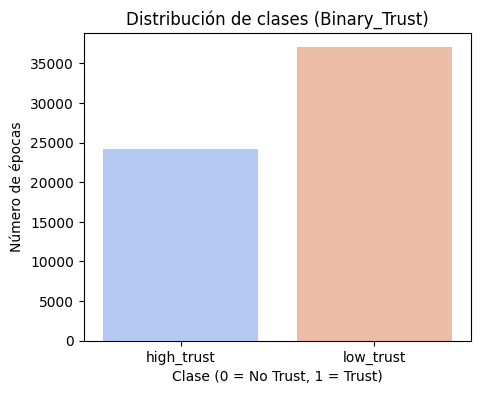

Distribución porcentual:
 Binary_Trust
low_trust     0.605469
high_trust    0.394531
Name: proportion, dtype: float64


In [15]:
plt.figure(figsize=(5,4))
sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm', order=['high_trust', 'low_trust'])
plt.title("Distribución de clases (Binary_Trust)")
plt.xlabel("Clase (0 = No Trust, 1 = Trust)")
plt.ylabel("Número de épocas")
plt.show()

print("Distribución porcentual:\n", eeg1['Binary_Trust'].value_counts(normalize=True))

## Red Neuronal EEGNet

In [16]:
from braindecode import EEGClassifier
from braindecode.models import EEGNet
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from skorch.helper import predefined_split

In [12]:
fs = 1 / (eeg1['latency'].iloc[1] - eeg1['latency'].iloc[0])
print("Frecuencia de muestreo (Hz):", fs)

Frecuencia de muestreo (Hz): 255.76583938041372


## Almacén de los datos

In [20]:
import os
def save_f1_history(clf, architecture, participant):
    f1_curve = clf.history_[:, 'f1_macro']
    df_new = pd.DataFrame({
        'epoch': range(1, len(f1_curve)+1),
        'f1': f1_curve,
        'architecture': architecture,
        'participant': participant
    })

    filename = "historial_f1_global.csv"

    if os.path.exists(filename):
        df_old = pd.read_csv(filename)
        df_final = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df_final = df_new

    df_final.to_csv(filename, index=False)
    print(f"Guardado en {filename}")


## Focal Loss

In [149]:
import torch.nn as nn
import torch.nn.functional as F
# Es una función de pérdida que nos sirve para clases desbalanceadas
# gamma controla cuánto penaliza la pérdida

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt) ** self.gamma * CE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


## Trial Wise

In [20]:
# Identificar todos los trials (epochs)
epochs = eeg1['epoch'].dropna().unique()

# Asociar cada trial a su etiqueta de confianza binaria
binary_trust_in_epoch = eeg1.groupby('epoch')['Binary_Trust'].first()

# Dividir trials en train, test y validación 
epochs_train, epochs_test = train_test_split(
    epochs,
    test_size=0.2,
    stratify=binary_trust_in_epoch.loc[epochs].values,
    random_state=42
)

# Dentro de train, split train/valid
epochs_train, epochs_valid = train_test_split(
    epochs_train,
    test_size=0.2,  
    stratify=binary_trust_in_epoch[epochs_train],
    random_state=42
)

df_train = eeg1[eeg1['epoch'].isin(epochs_train)].reset_index(drop=True)
df_valid = eeg1[eeg1['epoch'].isin(epochs_valid)].reset_index(drop=True)
df_test  = eeg1[eeg1['epoch'].isin(epochs_test)].reset_index(drop=True)

def make_trial_windows(df, window_size, stride):
    trials = df['epoch'].unique()
    X_list, y_list = [], []

    for trial in trials:
        trial_df = df[df['epoch']==trial].drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')
        trial_signals = trial_df.values  
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        label_bin = 0 if label=='low_trust' else 1

        # Extraer ventanas con stride
        for start in range(0, trial_signals.shape[0] - window_size + 1, stride):
            window = trial_signals[start:start+window_size, :]
            X_list.append(window.T)  
            y_list.append(label_bin)

    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.long)

    return X_tensor, y_tensor

X_train_t, y_train_t = make_trial_windows(df_train, window_size=256, stride=32)
X_valid_t, y_valid_t = make_trial_windows(df_valid, window_size=256, stride=32)
X_test_t,  y_test_t  = make_trial_windows(df_test,  window_size=256, stride=32)

print(X_train_t.shape, y_train_t.shape)




C:\Users\crist\AppData\Local\Temp\ipykernel_42712\2140446122.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  X_tensor = torch.tensor(X_list, dtype=torch.float32)


torch.Size([500, 19, 256]) torch.Size([500])


## Selección de características

### Métodos de filtro

In [ ]:
# Selección de canales (ANOVA) 
from sklearn.feature_selection import f_classif
import numpy as np

# Convertimos a numpy y aplanamos por tiempo para tener una feature por canal
X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Calculamos F y p-values
F_values, pvals = f_classif(X_train_mean, y_np)

# Escogemos los canales con p<0.05 (significativos)
k = 10  
selected_channels = np.argsort(F_values)[-k:] 
print("Canales seleccionados:", selected_channels)


# Filtramos los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]

print("Nueva forma de X_train:", X_train_t.shape)


Canales seleccionados: [11 18  5 12 14  2 16  3  6  9]
Nueva forma de X_train: torch.Size([568, 10, 256])


In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Mutual information
mi = mutual_info_classif(X_train_mean, y_np, random_state=42)
selected_channels = np.argsort(mi)[-10:] 

print("Canales seleccionados (MI):", selected_channels)

# Filtra los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Nueva forma de X_train:", X_train_t.shape)

Canales seleccionados (MI): [ 1 14  8  6  9  5  7  4 13 18]
Nueva forma de X_train: torch.Size([568, 10, 256])


### Método híbrido (filter+wrapper)

In [167]:
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

X_mean = X_train_t.numpy().mean(axis=2)
mi = mutual_info_classif(X_mean, y_train_t.numpy(), random_state=42)
top_k = min(14, X_mean.shape[1])
top_channels = np.argsort(mi)[-top_k:]
X_filtered = X_mean[:, top_channels]

wrapper = SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        n_features_to_select=min(10, top_k),
        direction='forward',
        n_jobs=-1
    )
wrapper.fit(X_filtered, y_train_t.numpy())
selected_channels = top_channels[wrapper.get_support()]
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Canales finales (híbrido):", selected_channels)


Canales finales (híbrido): [12 11  1  8  6  9  7  4 13 18]


## Normalización de los datos

In [21]:
mean = X_train_t.mean(dim=(0,2), keepdim=True) 
std  = X_train_t.std(dim=(0,2), keepdim=True)
X_train_t = (X_train_t - mean) / (std + 1e-8)
X_valid_t = (X_valid_t - mean) / (std + 1e-8)
X_test_t  = (X_test_t - mean) / (std + 1e-8)


In [16]:
overlap = set(epochs_train).intersection(set(epochs_test))
print("Épocas repetidas en train y test:", overlap)

Épocas repetidas en train y test: set()


In [17]:
print("Train windows:", X_train_t.shape[0])
print("Valid windows:", X_valid_t.shape[0])
print("Test windows:",  X_test_t.shape[0])


Train windows: 500
Valid windows: 101
Test windows: 142


## Modelo y entrenamiento

### Creación del modelo

In [ ]:
chans = 19     
nb_classes = 2   

model = EEGNet(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
    F1=8,F2=16,
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss()

### Entrenamiento del modelo

In [15]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[f1_macro],
    max_epochs=30,
    device='cpu',
)


In [ ]:
clf.fit(X_train_t, y_train_t)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4282        0.7098       0.5050        0.6976  2.7957
      2      0.3785        0.6946       0.5248        0.6992  2.1347
      3      0.3355        0.6871       0.5050        0.7007  0.7828
      4      0.3355        0.6622       0.5050        0.7045  0.7178
      5      0.3355        0.6389       0.5050        0.7091  0.5640
      6      0.3355        0.6386       0.5050        0.7149  0.5907
      7      0.3355        0.6345       0.5050        0.7217  0.6900
      8      0.3355        0.6195       0.5050        0.7287  1.0555
      9      0.3355        0.6166       0.5050        0.7372  2.0165
     10      0.3355        0.5923       0.5050        0.7473  1.0770
     11      0.3355        0.6191       0.5050        0.7560  2.0348
     12      0.3355        0.5928       0.5050        0.7651  1.1126
     13      0.4187        0.6051 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 19, 256]              [1, 19, 256, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 19, 256]           [1, 8, 19, 257]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 19, 257]           [1, 8, 19, 257]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 19, 257]           [1, 16, 1, 257]           --                        [19, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 19, 1]            304                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 257]           [1, 16, 1, 257]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 257]           [1, 16, 1, 257]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 257]           [1, 16, 1, 64]            --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 64]            [1, 16, 1, 64]            --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 64]            [1, 16, 1, 65]            256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 65]            [1, 16, 1, 65]            256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 65]            [1, 16, 1, 65]            32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 65]            [1, 16, 1, 65]            --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 65]            [1, 16, 1, 8]             --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 8]             [1, 16, 1, 8]             --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 8]             [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 8]             [1, 2, 1, 1]              258                       [1, 8]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  ==========================================================================================================

### Test

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[66 25]
 [36 15]]
              precision    recall  f1-score   support

           0       0.65      0.73      0.68        91
           1       0.38      0.29      0.33        51

    accuracy                           0.57       142
   macro avg       0.51      0.51      0.51       142
weighted avg       0.55      0.57      0.56       142



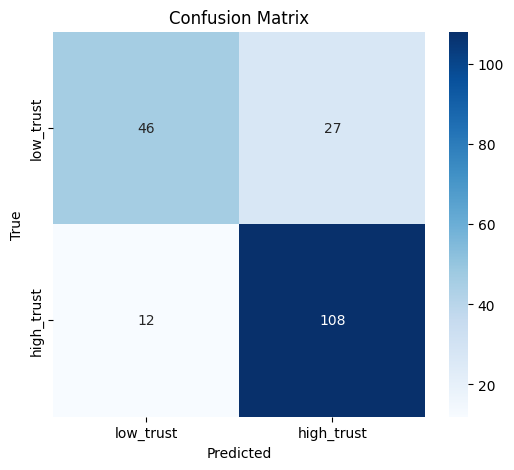

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_valid_t)[:, 1] 
y_true = y_valid_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.434


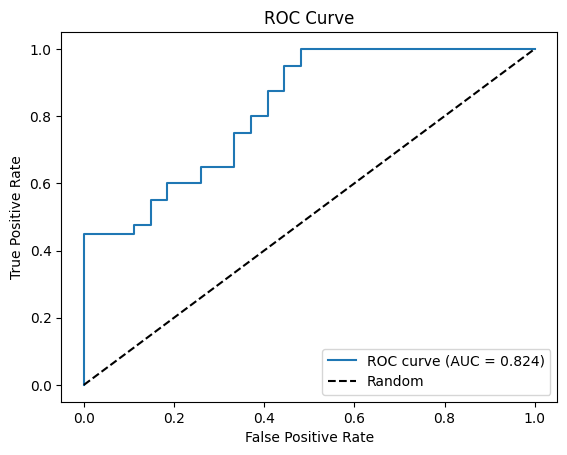

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Se almacenan los valores de f1-score

In [21]:
save_f1_history(
    clf=clf,
    architecture="EEGNet",
    participant="P22"
)

Guardado en historial_f1_global.csv


### RED EEGNeX

In [23]:
from braindecode.models import EEGNeX

In [ ]:
chans = 19      
nb_classes = 2   

model = EEGNeX(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
)

In [25]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[f1_macro],
    max_epochs=30,
    device='cpu',
)


In [26]:
clf.fit(
    X_train_t, 
    y_train_t, 
)

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1028.)
  return F.conv2d(


  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3823        0.6760       0.5050        0.7017  9.1544
      2      0.4669        0.6475       0.5347        0.7118  6.6238
      3      0.4679        0.6189       0.5149        0.7784  7.2138
      4      0.4648        0.5827       0.4950        0.9202  7.1551
      5      0.5545        0.5313       0.5644        1.0900  6.3791
      6      0.5095        0.4931       0.5446        1.0447  6.3475
      7      0.4374        0.4810       0.5050        1.0049  6.1179
      8      0.4448        0.4826       0.4554        1.2383  6.9752
      9      0.4607        0.4353       0.5149        1.1870  6.8993
     10      0.4294        0.3839       0.4455        1.1929  10.3447
     11      0.4680        0.3752       0.5248        1.2075  11.1331
     12      0.4438        0.3553       0.4752        1.1672  10.7629
     13      0.3484        0.31

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNeX (EEGNeX)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Sequential (block_1): 1-1                                  [1, 19, 256]              [1, 8, 19, 256]           --                        --
  │    └─Rearrange (0): 2-1                                    [1, 19, 256]              [1, 1, 19, 256]           --                        --
  │    └─Conv2d (1): 2-2                                       [1, 1, 19, 256]           [1, 8, 19, 256]           512                       [1, 64]
  │    └─BatchNorm2d (2): 2-3                                  [1, 8, 19, 256]           [1, 8, 19, 256]           16                        --
  ├─Sequential (block_2): 1-2                                  [1, 8, 19, 256]           [1, 32, 19, 256]          --                        --
  │    └─Conv2d (0): 2-4                                       [1, 8, 19, 256]           [1, 32, 19, 256]          16,384                    [1, 64]
  │    └─BatchNorm2d (1): 2-5                                  [1, 32, 19, 256]          [1, 32, 19, 256]          64                        --
  ├─Sequential (block_3): 1-3                                  [1, 32, 19, 256]          [1, 64, 1, 64]            --                        --
  │    └─ParametrizedConv2dWithConstraint (0): 2-6             [1, 32, 19, 256]          [1, 64, 1, 256]           --                        [19, 1]
  │    │    └─ModuleDict (parametrizations): 3-1               --                        --                        1,216                     --
  │    └─BatchNorm2d (1): 2-7                                  [1, 64, 1, 256]           [1, 64, 1, 256]           128                       --
  │    └─ELU (2): 2-8                                          [1, 64, 1, 256]           [1, 64, 1, 256]           --                        --
  │    └─AvgPool2d (3): 2-9                                    [1, 64, 1, 256]           [1, 64, 1, 64]            --                        [1, 4]
  │    └─Dropout (4): 2-10                                     [1, 64, 1, 64]            [1, 64, 1, 64]            --                        --
  ├─Sequential (block_4): 1-4                                  [1, 64, 1, 64]            [1, 32, 1, 64]            --                        --
  │    └─Conv2d (0): 2-11                                      [1, 64, 1, 64]            [1, 32, 1, 64]            32,768                    [1, 16]
  │    └─BatchNorm2d (1): 2-12                                 [1, 32, 1, 64]            [1, 32, 1, 64]            64                        --
  ├─Sequential (block_5): 1-5                                  [1, 32, 1, 64]            [1, 64]                   --                        --
  │    └─Conv2d (0): 2-13                                      [1, 32, 1, 64]            [1, 8, 1, 64]             4,096                     [1, 16]
  │    └─BatchNorm2d (1): 2-14                                 [1, 8, 1, 64]             [1, 8, 1, 64]             16                        --
  │    └─ELU (2): 2-15                                         [1, 8, 1, 64]             [1, 8, 1, 64]             --                        --
  │    └─AvgPool2d (3): 2-16                                   [1, 8, 1, 64]             [1, 8, 1, 8]              --                        [1, 8]
  │    └─Dropout (4): 2-17                                     [1, 8, 1, 8]              [1, 8, 1, 8]     

In [38]:
print(X_train_t.shape)


torch.Size([500, 19, 256])


In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[65 26]
 [32 19]]
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        91
           1       0.42      0.37      0.40        51

    accuracy                           0.59       142
   macro avg       0.55      0.54      0.54       142
weighted avg       0.58      0.59      0.59       142



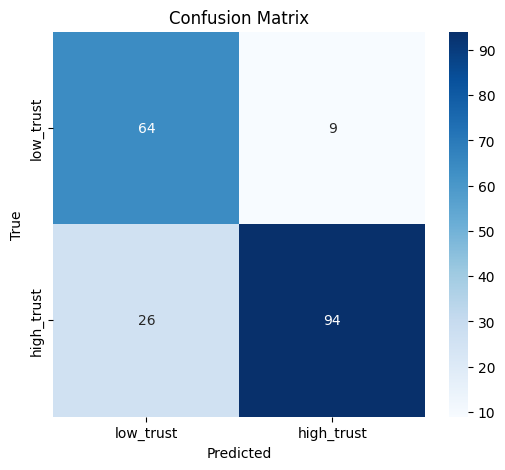

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_valid_t)[:, 1]  
y_true = y_valid_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.334


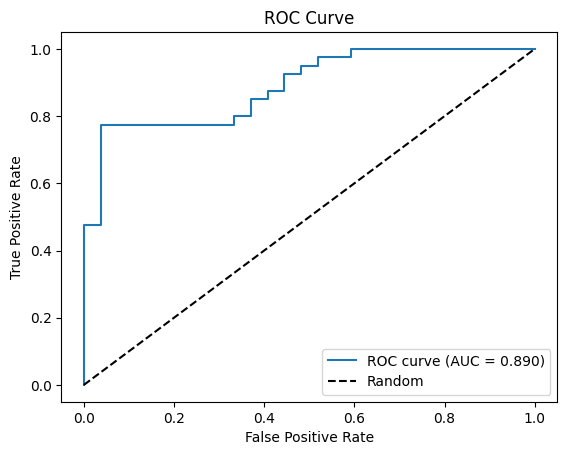

In [165]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [29]:
save_f1_history(
    clf=clf,
    architecture="EEGNeX",
    participant="P22"
)

Guardado en historial_f1_global.csv


## AttentionBaseNet

In [22]:
from braindecode.models import AttentionBaseNet


In [33]:
model = AttentionBaseNet(
    n_chans=19,
    n_outputs=2,
    n_times=256,
    drop_prob_inp=0.5,
    drop_prob_attn= 0.2,

)


In [34]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss()

In [35]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[f1_macro 
               ],
    max_epochs=30,
    device='cpu',
)


In [36]:
clf.fit(
    X_train_t, 
    y_train_t, 
)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.5113        0.7045       0.5842        0.6959  2.0173
      2      0.4784        0.6848       0.5644        0.6986  0.8815
      3      0.5021        0.6687       0.5842        0.6995  0.9356
      4      0.5185        0.6436       0.5941        0.7037  0.9072
      5      0.5499        0.6333       0.6040        0.7098  0.9249
      6      0.5846        0.6267       0.6238        0.7217  0.8706
      7      0.6032        0.6009       0.6337        0.7382  1.5683
      8      0.6032        0.5869       0.6337        0.7701  1.4113
      9      0.6117        0.5931       0.6337        0.8005  2.3393
     10      0.5908        0.5858       0.6139        0.8626  1.7694
     11      0.5603        0.5712       0.5941        0.8944  1.5643
     12      0.5345        0.5593       0.5842        0.8971  1.5320
     13      0.5095        0.5376 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  AttentionBaseNet (AttentionBaseNet)                          [1, 19, 256]              [1, 2]                    --                        --
  ├─_FeatureExtractor (input_block): 1-1                       [1, 19, 256]              [1, 40, 1, 13]            --                        --
  │    └─Ensure4d (ensure4d): 2-1                              [1, 19, 256]              [1, 19, 256, 1]           --                        --
  │    └─Rearrange (rearrange_input): 2-2                      [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  │    └─Conv2d (temporal_conv): 2-3                           [1, 1, 19, 256]           [1, 40, 19, 256]          1,000                     [1, 25]
  │    └─BatchNorm2d (intermediate_bn): 2-4                    [1, 40, 19, 256]          [1, 40, 19, 256]          80                        --
  │    └─Conv2d (spatial_conv): 2-5                            [1, 40, 19, 256]          [1, 40, 1, 256]           760                       [19, 1]
  │    └─BatchNorm2d (bn): 2-6                                 [1, 40, 1, 256]           [1, 40, 1, 256]           80                        --
  │    └─ELU (nonlinearity): 2-7                               [1, 40, 1, 256]           [1, 40, 1, 256]           --                        --
  │    └─AvgPool2d (pool): 2-8                                 [1, 40, 1, 256]           [1, 40, 1, 13]            --                        [1, 75]
  │    └─Dropout (dropout): 2-9                                [1, 40, 1, 13]            [1, 40, 1, 13]            --                        --
  ├─Sequential (channel_expansion): 1-2                        [1, 40, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─Conv2d (0): 2-10                                      [1, 40, 1, 13]            [1, 16, 1, 13]            640                       [1, 1]
  │    └─BatchNorm2d (1): 2-11                                 [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    └─ELU (2): 2-12                                         [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  ├─_ChannelAttentionBlock (channel_attention_block): 1-3      [1, 16, 1, 13]            [1, 16, 1, 1]             --                        --
  │    └─Sequential (conv): 2-13                               [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 16, 1, 13]            [1, 16, 1, 13]            240                       [1, 15]
  │    │    └─Conv2d (1): 3-2                                  [1, 16, 1, 13]            [1, 16, 1, 13]            256                       [1, 1]
  │    │    └─BatchNorm2d (2): 3-3                             [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    │    └─ELU (3): 3-4                                     [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─AvgPool2d (pool): 2-14                                [1, 16, 1, 13]            [1, 16, 1, 1]             --                        [1, 8]
  │    └─Dropout (dropout): 2-15                               [1, 16, 1, 1]             [1, 16, 1, 1]             --                        --
  ├─Sequential (final_layer): 1-4                              [1, 16, 1, 1]             [1, 2]            

In [37]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[68 23]
 [19 32]]
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        91
           1       0.58      0.63      0.60        51

    accuracy                           0.70       142
   macro avg       0.68      0.69      0.68       142
weighted avg       0.71      0.70      0.71       142



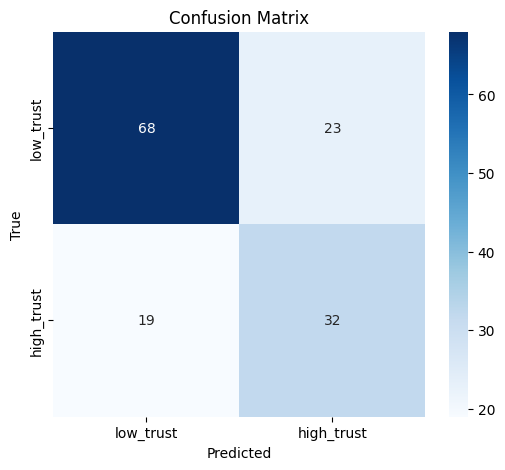

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Opcional: nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [40]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.653


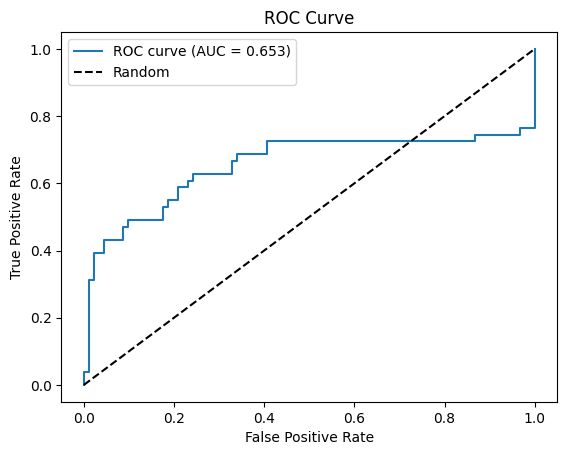

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [39]:
save_f1_history(
    clf=clf,
    architecture="AttentionBaseNet",
    participant="P22"
)

Guardado en historial_f1_global.csv


In [42]:
import os
import pickle

subject_id = 'P22'
folder_path = 'artifacts/p22'
os.makedirs(folder_path, exist_ok=True)

# Guardar modelo y configuración
try:
    # Guardamos los pesos del modelo y optimizador 
    clf.save_params(
        f_params=os.path.join(folder_path, f'model_weights_{subject_id}.pt'),
        f_optimizer=os.path.join(folder_path, f'opt_{subject_id}.pt'),
        f_history=os.path.join(folder_path, f'history_{subject_id}.json')
    )
    
    # Guardamos los hiperparámetros 
    config_params = clf.get_params()
    config_params.pop('module', None) 
    
    with open(os.path.join(folder_path, f'config_{subject_id}.pkl'), 'wb') as f:
        pickle.dump(config_params, f)

except RuntimeError:
    import torch
    torch.save(clf.module_.state_dict(), os.path.join(folder_path, f'state_dict_{subject_id}.pt'))

# GUARDAR PREDICCIONES 
y_pred = clf.predict(X_test_t)
y_probs = clf.predict_proba(X_test_t)[:, 1]

df_preds = pd.DataFrame({
    'Real': y_test_t.cpu().numpy() if hasattr(y_test_t, 'cpu') else y_test_t,
    'Prediccion': y_pred,
    'Probabilidad': y_probs
})

df_preds.to_excel(os.path.join(folder_path, f'predicciones_{subject_id}.xlsx'), index=False)

